# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. **Visualize strain maps**

# Notebook 7: Visualize strain maps

In this step the strain maps are visualized.

### Import packages, load data

In [58]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit
from time import time
from gc import collect
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing
from scipy.ndimage.filters import maximum_filter
from scipy.signal import medfilt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from py4DSTEM.process.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray

In [6]:
# # Load the lattice vectors maps
# fp_uvmap = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
# browser.show_dataobjects()
# strain_maps = browser.get_dataobject(0)

# # Load the DF image
# fp_DFimage = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/DF_image.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
# browser.show_dataobjects()
# DFimage = browser.get_dataobject(0)

In [7]:
# Load the lattice vectors maps
fp_uvmap = "/home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_uvmap)
browser.show_dataobjects()
strain_maps = browser.get_dataobject(0)

# Load the DF image
fp_DFimage = "/home/ben/Data/20180905_FePO4_unlithiated/processing/DF_image.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_DFimage)
browser.show_dataobjects()
DF_image = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    strain_maps                         RealSlice           
 Index                  Name                        Type        
   0    realslice_0                         RealSlice           


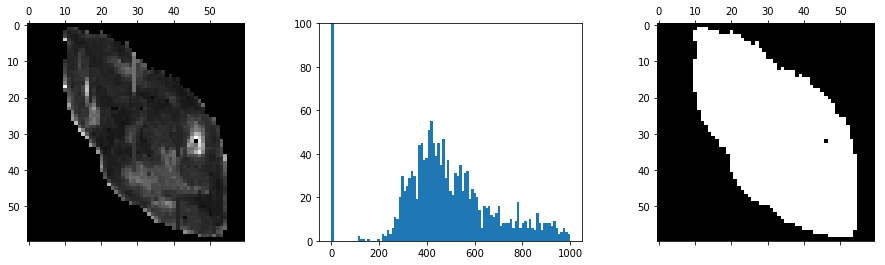

In [370]:
# Make a mask from the virtual dark-field image

mask = (DF_image.data2D>0)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
ax1.matshow(DF_image.data2D)
ax2.hist(DF_image.data2D.ravel(),bins=np.linspace(0,1000,100))
ax2.set_ylim([0,100])
ax3.matshow(mask)
plt.show()

### Square layout

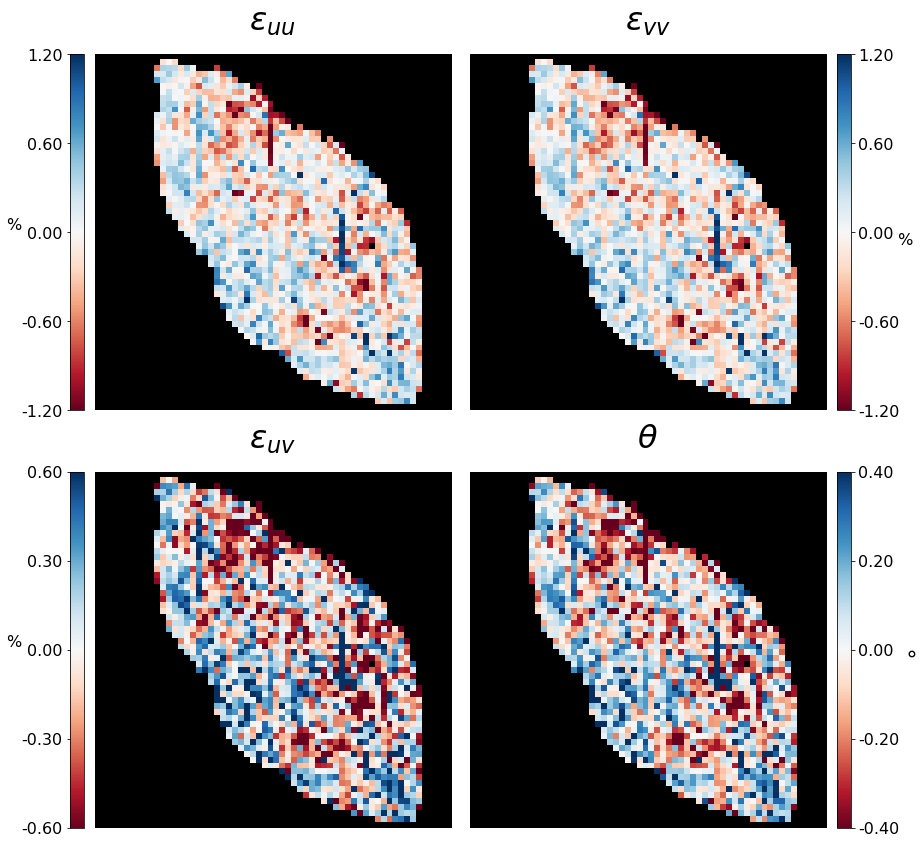

In [198]:
# Plot data
# Unfiltered
# Sqaure layout

titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_uu_range = [-1.2,1.2] # In percentage
e_vv_range = [-1.2,1.2] # In percentage
e_uv_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_ave, e_uu_std = np.average(strain_maps.data2D['e_uu'][mask]),np.std(strain_maps.data2D['e_uu'][mask])
e_vv_ave, e_vv_std = np.average(strain_maps.data2D['e_vv'][mask]),np.std(strain_maps.data2D['e_vv'][mask])
e_uv_ave, e_uv_std = np.average(strain_maps.data2D['e_uv'][mask]),np.std(strain_maps.data2D['e_uv'][mask])
theta_ave, theta_std = np.average(strain_maps.data2D['theta'][mask]),np.std(strain_maps.data2D['theta'][mask])

if automate_colorscale:
    e_uu_range = [-n_stds*e_uu_std*100,n_stds*e_uu_std*100]
    e_vv_range = [-n_stds*e_vv_std*100,n_stds*e_vv_std*100]
    e_uv_range = [-n_stds*e_uv_std*100,n_stds*e_uv_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(14,15),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(strain_maps.data2D['e_uu'],vmin=e_uu_range[0]/100., vmax=e_uu_range[1]/100., cmap="RdBu")
cax12 = ax12.matshow(strain_maps.data2D['e_uu'],vmin=e_vv_range[0]/100., vmax=e_vv_range[1]/100., cmap="RdBu")
cax21 = ax21.matshow(strain_maps.data2D['e_uu'],vmin=e_uv_range[0]/100., vmax=e_uv_range[1]/100., cmap="RdBu")
cax22 = ax22.matshow(strain_maps.data2D['e_uu'],vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_uu_range[0]/100.,e_uu_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_vv_range[0]/100.,e_vv_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_uv_range[0]/100.,e_uv_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uu_range[0],e_uu_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_vv_range[0],e_vv_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uv_range[0],e_uv_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')

cbax11.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax12.set_ylabel(" %", size=ticklabelsize, rotation=0)
cbax21.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax22.set_ylabel(r" $^\circ$", size=2*ticklabelsize, rotation=0)

cbax11.yaxis.set_label_position('left')
cbax12.yaxis.set_label_position('right')
cbax21.yaxis.set_label_position('left')
cbax22.yaxis.set_label_position('right')


ax11.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax12.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax21.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()

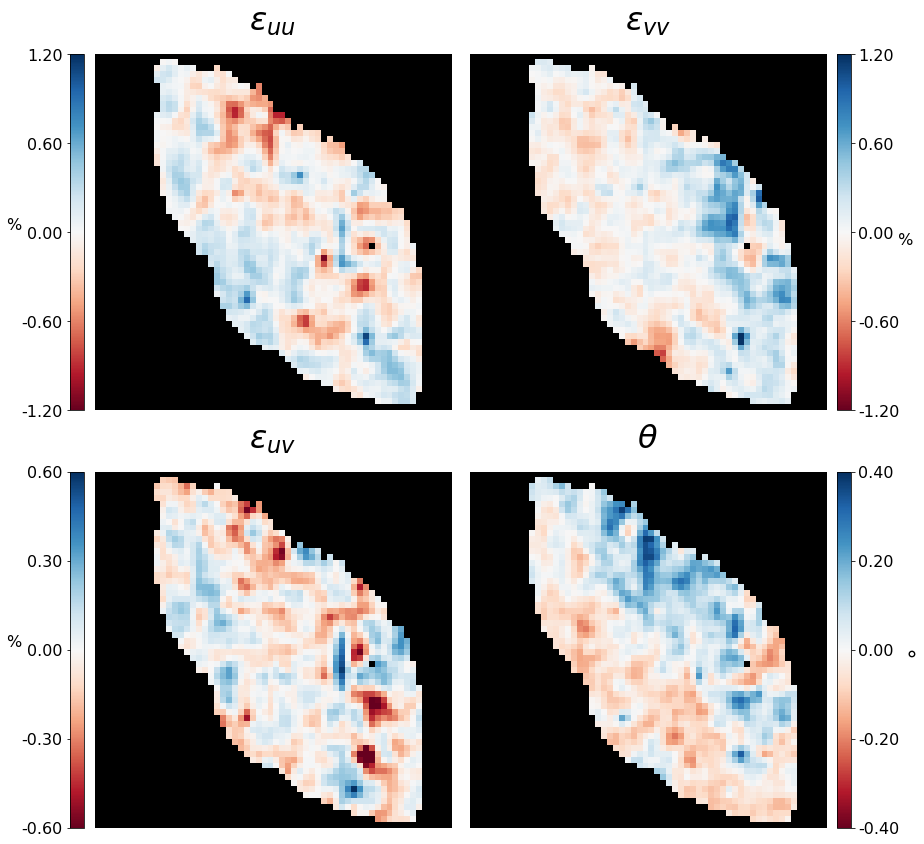

In [210]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

sigma = .8
titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_uu_range = [-1.2,1.2] # In percentage
e_vv_range = [-1.2,1.2] # In percentage
e_uv_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave, e_uu_std = np.average(e_uu_smoothed[mask]),np.std(e_uu_smoothed[mask])
e_vv_ave, e_vv_std = np.average(e_vv_smoothed[mask]),np.std(e_vv_smoothed[mask])
e_uv_ave, e_uv_std = np.average(e_uv_smoothed[mask]),np.std(e_uv_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_uu_range = [-n_stds*e_uu_std*100,n_stds*e_uu_std*100]
    e_vv_range = [-n_stds*e_vv_std*100,n_stds*e_vv_std*100]
    e_uv_range = [-n_stds*e_uv_std*100,n_stds*e_uv_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(14,15),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(e_uu_smoothed,vmin=e_uu_range[0]/100., vmax=e_uu_range[1]/100., cmap="RdBu")
cax12 = ax12.matshow(e_vv_smoothed,vmin=e_vv_range[0]/100., vmax=e_vv_range[1]/100., cmap="RdBu")
cax21 = ax21.matshow(e_uv_smoothed,vmin=e_uv_range[0]/100., vmax=e_uv_range[1]/100., cmap="RdBu")
cax22 = ax22.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_uu_range[0]/100.,e_uu_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_vv_range[0]/100.,e_vv_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_uv_range[0]/100.,e_uv_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uu_range[0],e_uu_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_vv_range[0],e_vv_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uv_range[0],e_uv_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')

cbax11.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax12.set_ylabel(" %", size=ticklabelsize, rotation=0)
cbax21.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax22.set_ylabel(r" $^\circ$", size=2*ticklabelsize, rotation=0)

cbax11.yaxis.set_label_position('left')
cbax12.yaxis.set_label_position('right')
cbax21.yaxis.set_label_position('left')
cbax22.yaxis.set_label_position('right')


ax11.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax12.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax21.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()

### Horizontal layout

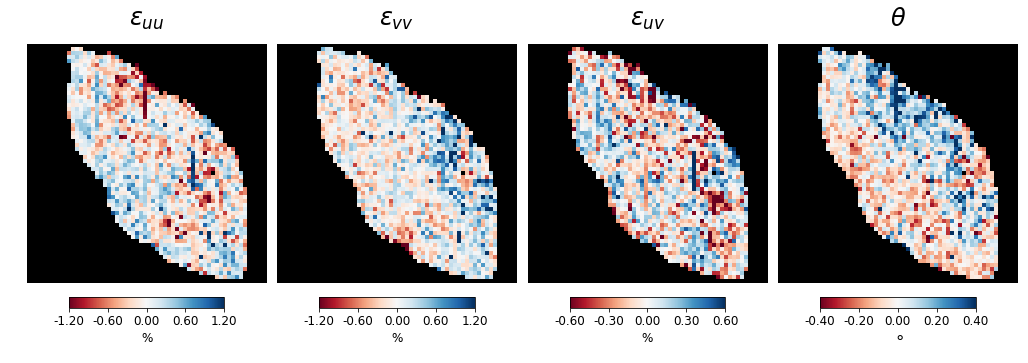

In [340]:
# Plot data
# Unfiltered
# Sqaure layout

sigma = .8
titlesize=24
ticklabelsize=12

# Set colorscales
automate_colorscale = False
n_stds=3

e_uu_range = [-1.2,1.2] # In percentage
e_vv_range = [-1.2,1.2] # In percentage
e_uv_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_ave, e_uu_std = np.average(strain_maps.data2D['e_uu'][mask]),np.std(strain_maps.data2D['e_uu'][mask])
e_vv_ave, e_vv_std = np.average(strain_maps.data2D['e_vv'][mask]),np.std(strain_maps.data2D['e_vv'][mask])
e_uv_ave, e_uv_std = np.average(strain_maps.data2D['e_uv'][mask]),np.std(strain_maps.data2D['e_uv'][mask])
theta_ave, theta_std = np.average(strain_maps.data2D['theta'][mask]),np.std(strain_maps.data2D['theta'][mask])

if automate_colorscale:
    e_uu_range = [-n_stds*e_uu_std*100,n_stds*e_uu_std*100]
    e_vv_range = [-n_stds*e_vv_std*100,n_stds*e_vv_std*100]
    e_uv_range = [-n_stds*e_uv_std*100,n_stds*e_uv_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]


    
### Plot ###
fig = plt.figure(figsize=(32,5))
           
gs = gridspec.GridSpec(2, 12, width_ratios=[1,5,1,1,5,1,1,5,1,1,5,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,9:12])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,10])

gs.update(wspace=0.15, hspace=0.05)
    
cax1 = ax1.matshow(strain_maps.data2D['e_uu'],vmin=e_uu_range[0]/100., vmax=e_uu_range[1]/100., cmap="RdBu")
cax2 = ax2.matshow(strain_maps.data2D['e_vv'],vmin=e_vv_range[0]/100., vmax=e_vv_range[1]/100., cmap="RdBu")
cax3 = ax3.matshow(strain_maps.data2D['e_uv'],vmin=e_uv_range[0]/100., vmax=e_uv_range[1]/100., cmap="RdBu")
cax4 = ax4.matshow(strain_maps.data2D['theta'],vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_uu_range[0]/100.,e_uu_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_vv_range[0]/100.,e_vv_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_uv_range[0]/100.,e_uv_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uu_range[0],e_uu_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_vv_range[0],e_vv_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uv_range[0],e_uv_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

ax1.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax2.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax3.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

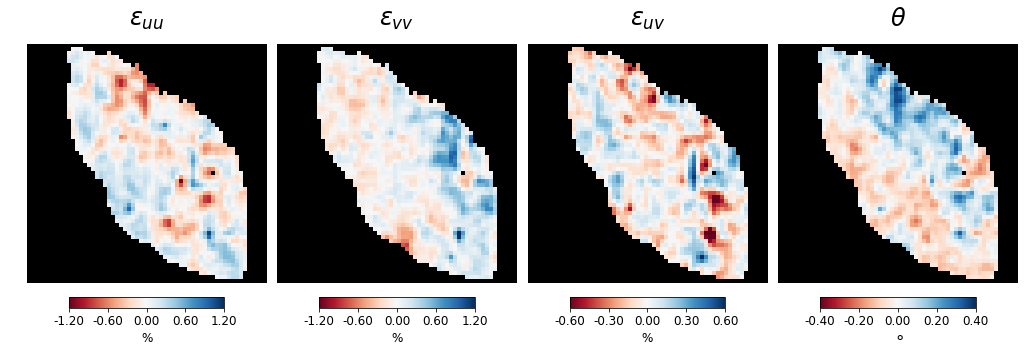

In [341]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

sigma = .8
titlesize=24
ticklabelsize=12

# Set colorscales
automate_colorscale = False
n_stds=3

e_uu_range = [-1.2,1.2] # In percentage
e_vv_range = [-1.2,1.2] # In percentage
e_uv_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave, e_uu_std = np.average(e_uu_smoothed[mask]),np.std(e_uu_smoothed[mask])
e_vv_ave, e_vv_std = np.average(e_vv_smoothed[mask]),np.std(e_vv_smoothed[mask])
e_uv_ave, e_uv_std = np.average(e_uv_smoothed[mask]),np.std(e_uv_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_uu_range = [-n_stds*e_uu_std*100,n_stds*e_uu_std*100]
    e_vv_range = [-n_stds*e_vv_std*100,n_stds*e_vv_std*100]
    e_uv_range = [-n_stds*e_uv_std*100,n_stds*e_uv_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]


    
### Plot ###
fig = plt.figure(figsize=(32,5))
           
gs = gridspec.GridSpec(2, 12, width_ratios=[1,5,1,1,5,1,1,5,1,1,5,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,9:12])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,10])

gs.update(wspace=0.15, hspace=0.05)
    
cax1 = ax1.matshow(e_uu_smoothed,vmin=e_uu_range[0]/100., vmax=e_uu_range[1]/100., cmap="RdBu")
cax2 = ax2.matshow(e_vv_smoothed,vmin=e_vv_range[0]/100., vmax=e_vv_range[1]/100., cmap="RdBu")
cax3 = ax3.matshow(e_uv_smoothed,vmin=e_uv_range[0]/100., vmax=e_uv_range[1]/100., cmap="RdBu")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_uu_range[0]/100.,e_uu_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_vv_range[0]/100.,e_vv_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_uv_range[0]/100.,e_uv_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uu_range[0],e_uu_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_vv_range[0],e_vv_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_uv_range[0],e_uv_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

ax1.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax2.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax3.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

### Horizontal, share colorbar

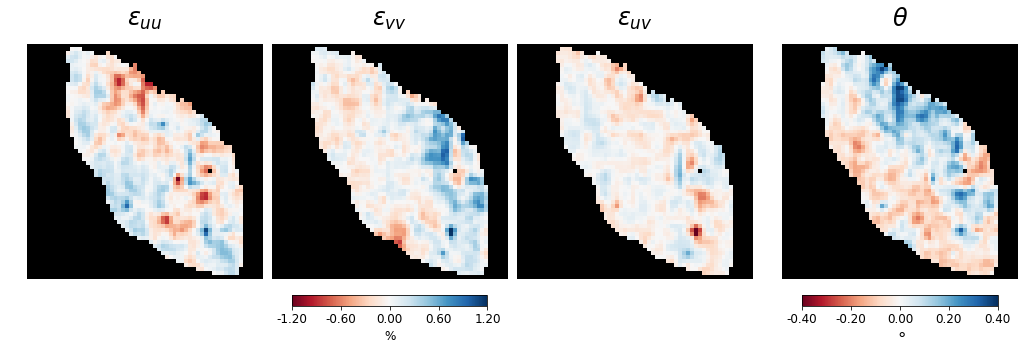

In [355]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

sigma = .8
titlesize=24
ticklabelsize=12

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave = np.average(e_uu_smoothed[mask])
e_vv_ave = np.average(e_vv_smoothed[mask])
e_uv_ave = np.average(e_uv_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,5))
           
gs = gridspec.GridSpec(2, 13, width_ratios=[1,20,1,1,20,1,1,20,1,1,1,20,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,10:13])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,11])

gs.update(wspace=0.15, hspace=0.05)
    
cax1 = ax1.matshow(e_uu_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax2 = ax2.matshow(e_vv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax3 = ax3.matshow(e_uv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cb1.remove()
cb3.remove()

ax1.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax2.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax3.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

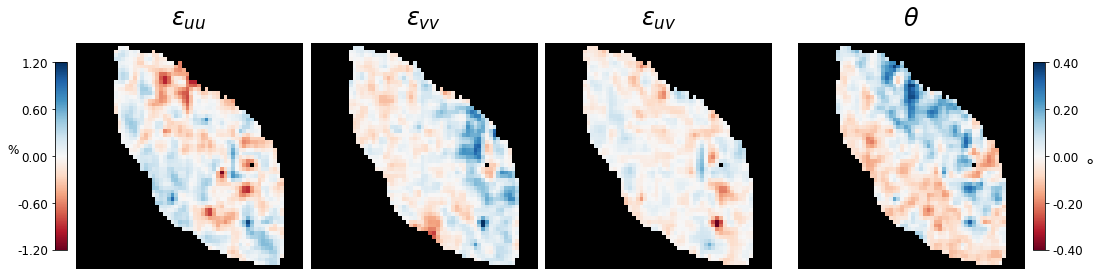

In [369]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

sigma = .8
titlesize=24
ticklabelsize=12

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave = np.average(e_uu_smoothed[mask])
e_vv_ave = np.average(e_vv_smoothed[mask])
e_uv_ave = np.average(e_uv_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,5))
           
gs = gridspec.GridSpec(3, 15, width_ratios=[1.3,1,20,1,1,20,1,1,20,1,1,1,20,1,1.3], height_ratios=[1,5, 1])
gs.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs[:,1:4])
ax2 = plt.subplot(gs[:,4:7])
ax3 = plt.subplot(gs[:,7:10,])
ax4 = plt.subplot(gs[:,11:14])

cbax1 = plt.subplot(gs[1,0])
cbax4 = plt.subplot(gs[1,14])

gs.update(wspace=0.15, hspace=0.05)
    
cax1 = ax1.matshow(e_uu_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax2 = ax2.matshow(e_vv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax3 = ax3.matshow(e_uv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cbax1.yaxis.set_ticks_position('left')
cbax1.yaxis.set_label_position('left')

ax1.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax2.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax3.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

### Rotate coordinates

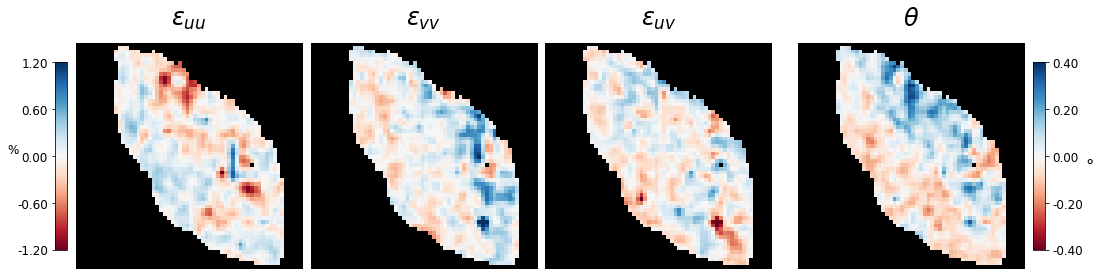

In [390]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

rotation = 30 # in degrees
sigma = .8
titlesize=24
ticklabelsize=12

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees

# Rotate data
costheta = np.cos(rotation*np.pi/180.)
sintheta = np.cos(rotation*np.pi/180.)
e_uu_rotated = np.empty_like(strain_maps.data2D['e_uu'])
e_vv_rotated = np.empty_like(strain_maps.data2D['e_vv'])
e_uv_rotated = np.empty_like(strain_maps.data2D['e_uv'])
for Rx in range(strain_maps.R_Nx):
    for Ry in range(strain_maps.R_Ny):
        e_uu_rotated[Rx,Ry] = costheta*strain_maps.data2D['e_uu'][Rx,Ry] + sintheta*strain_maps.data2D['e_uv'][Rx,Ry]
        e_vv_rotated[Rx,Ry] = -sintheta*strain_maps.data2D['e_uv'][Rx,Ry] + costheta*strain_maps.data2D['e_vv'][Rx,Ry]
        e_uv_rotated[Rx,Ry] = -sintheta*strain_maps.data2D['e_uu'][Rx,Ry] + costheta*strain_maps.data2D['e_uv'][Rx,Ry]

# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_uu_rotated, medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_vv_rotated, medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_uv_rotated, medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave = np.average(e_uu_smoothed[mask])
e_vv_ave = np.average(e_vv_smoothed[mask])
e_uv_ave = np.average(e_uv_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,5))
           
gs = gridspec.GridSpec(3, 15, width_ratios=[1.3,1,20,1,1,20,1,1,20,1,1,1,20,1,1.3], height_ratios=[1,5, 1])
gs.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs[:,1:4])
ax2 = plt.subplot(gs[:,4:7])
ax3 = plt.subplot(gs[:,7:10,])
ax4 = plt.subplot(gs[:,11:14])

cbax1 = plt.subplot(gs[1,0])
cbax4 = plt.subplot(gs[1,14])

gs.update(wspace=0.15, hspace=0.05)
    
cax1 = ax1.matshow(e_uu_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax2 = ax2.matshow(e_vv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax3 = ax3.matshow(e_uv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cbax1.yaxis.set_ticks_position('left')
cbax1.yaxis.set_label_position('left')

ax1.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax2.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax3.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

0 degrees


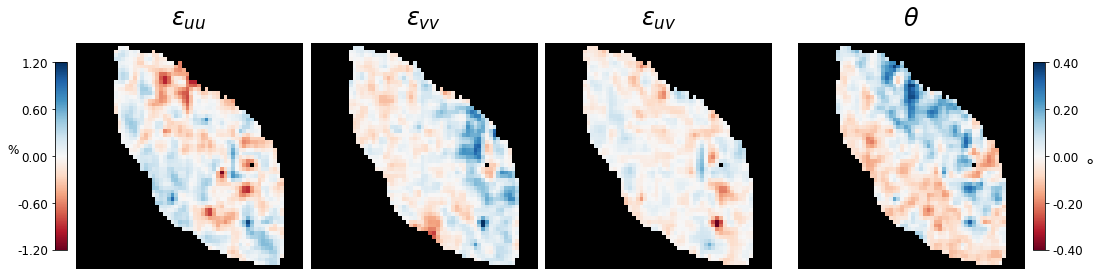

90 degrees


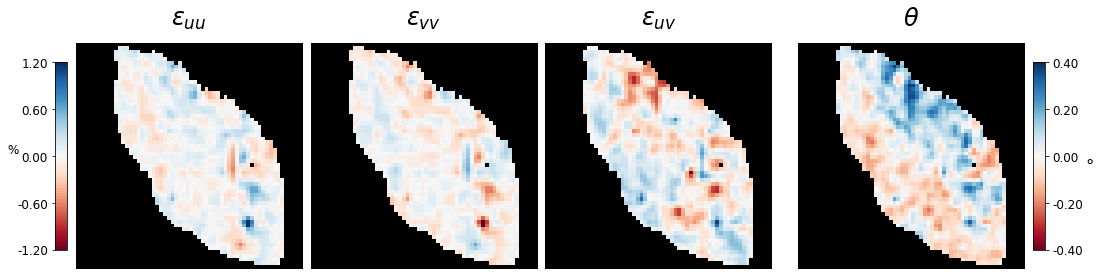

180 degrees


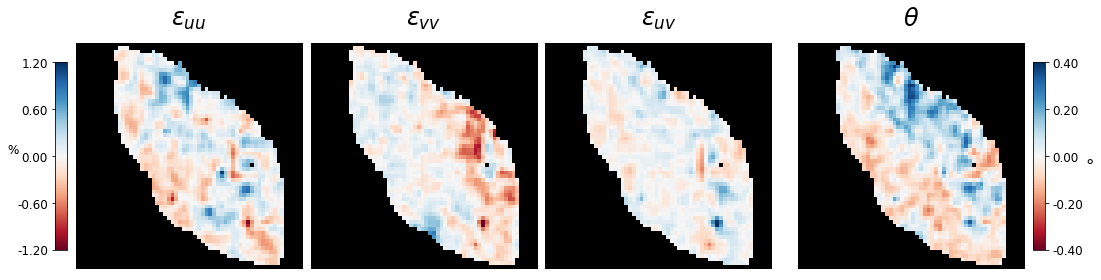

In [397]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

#rotations = [0,10,20,30,40,50,60,70,80,90] # in degrees
rotations = [0,90,180]
sigma = .8
titlesize=24
ticklabelsize=12

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


for rotation in rotations:
    print("{} degrees".format(rotation))
    
    # Rotate data
    costheta = np.cos(rotation*np.pi/180.)
    sintheta = np.sin(rotation*np.pi/180.)
    e_uu_rotated = np.empty_like(strain_maps.data2D['e_uu'])
    e_vv_rotated = np.empty_like(strain_maps.data2D['e_vv'])
    e_uv_rotated = np.empty_like(strain_maps.data2D['e_uv'])
    for Rx in range(strain_maps.R_Nx):
        for Ry in range(strain_maps.R_Ny):
            e_uu_rotated[Rx,Ry] = costheta*strain_maps.data2D['e_uu'][Rx,Ry] - sintheta*strain_maps.data2D['e_uv'][Rx,Ry]
            e_vv_rotated[Rx,Ry] = sintheta*strain_maps.data2D['e_uv'][Rx,Ry] + costheta*strain_maps.data2D['e_vv'][Rx,Ry]
            e_uv_rotated[Rx,Ry] = sintheta*strain_maps.data2D['e_uu'][Rx,Ry] + costheta*strain_maps.data2D['e_uv'][Rx,Ry]

    # Get smoothed image, mask, and colorscale ranges
    plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

    e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_uu_rotated, medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
    e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_vv_rotated, medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
    e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_uv_rotated, medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
    theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

    e_uu_ave = np.average(e_uu_smoothed[mask])
    e_vv_ave = np.average(e_vv_smoothed[mask])
    e_uv_ave = np.average(e_uv_smoothed[mask])
    theta_ave = np.average(theta_smoothed[mask])


    ### Plot ###
    fig = plt.figure(figsize=(32,5))

    gs = gridspec.GridSpec(3, 15, width_ratios=[1.3,1,20,1,1,20,1,1,20,1,1,1,20,1,1.3], height_ratios=[1,5, 1])
    gs.update(left=0.05, right=0.48, wspace=0.05)
    ax1 = plt.subplot(gs[:,1:4])
    ax2 = plt.subplot(gs[:,4:7])
    ax3 = plt.subplot(gs[:,7:10,])
    ax4 = plt.subplot(gs[:,11:14])

    cbax1 = plt.subplot(gs[1,0])
    cbax4 = plt.subplot(gs[1,14])

    gs.update(wspace=0.15, hspace=0.05)

    cax1 = ax1.matshow(e_uu_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
    cax2 = ax2.matshow(e_vv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
    cax3 = ax3.matshow(e_uv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
    cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

    # Black overlay
    ax1.matshow(plot_mask,cmap='gray')
    ax2.matshow(plot_mask,cmap='gray')
    ax3.matshow(plot_mask,cmap='gray')
    ax4.matshow(plot_mask,cmap='gray')

    # Colorbars

    cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
    cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

    cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
    cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

    cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
    cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

    cbax1.yaxis.set_ticks_position('left')
    cbax1.yaxis.set_label_position('left')

    ax1.set_title(r'$\epsilon_{uu}$',size=titlesize)
    ax2.set_title(r'$\epsilon_{vv}$',size=titlesize)
    ax3.set_title(r'$\epsilon_{uv}$',size=titlesize)
    ax4.set_title(r'$\theta$',size=titlesize)

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')

    plt.show()

### Save figures

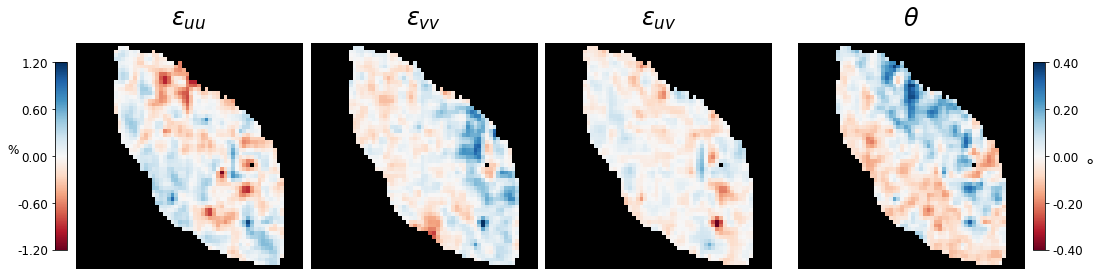

In [378]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps_horizontal_share_cbar_2.pdf"

# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

sigma = .8
titlesize=24
ticklabelsize=12

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_uu_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uu'], medfilt(np.where(mask,strain_maps.data2D['e_uu'],0),kernel_size=3)),sigma),0)
e_vv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_vv'], medfilt(np.where(mask,strain_maps.data2D['e_vv'],0),kernel_size=3)),sigma),0)
e_uv_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_uv'], medfilt(np.where(mask,strain_maps.data2D['e_uv'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_uu_ave = np.average(e_uu_smoothed[mask])
e_vv_ave = np.average(e_vv_smoothed[mask])
e_uv_ave = np.average(e_uv_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,5))
           
gs = gridspec.GridSpec(3, 15, width_ratios=[1.3,1,20,1,1,20,1,1,20,1,1,1,20,1,1.3], height_ratios=[1,5, 1])
gs.update(left=0.05, right=0.48, wspace=0.05)
ax1 = plt.subplot(gs[:,1:4])
ax2 = plt.subplot(gs[:,4:7])
ax3 = plt.subplot(gs[:,7:10,])
ax4 = plt.subplot(gs[:,11:14])

cbax1 = plt.subplot(gs[1,0])
cbax4 = plt.subplot(gs[1,14])

gs.update(wspace=0.15, hspace=0.05)
    
cax1 = ax1.matshow(e_uu_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax2 = ax2.matshow(e_vv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax3 = ax3.matshow(e_uv_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cbax1.yaxis.set_ticks_position('left')
cbax1.yaxis.set_label_position('left')

ax1.set_title(r'$\epsilon_{uu}$',size=titlesize)
ax2.set_title(r'$\epsilon_{vv}$',size=titlesize)
ax3.set_title(r'$\epsilon_{uv}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.savefig(savepath)
plt.show()

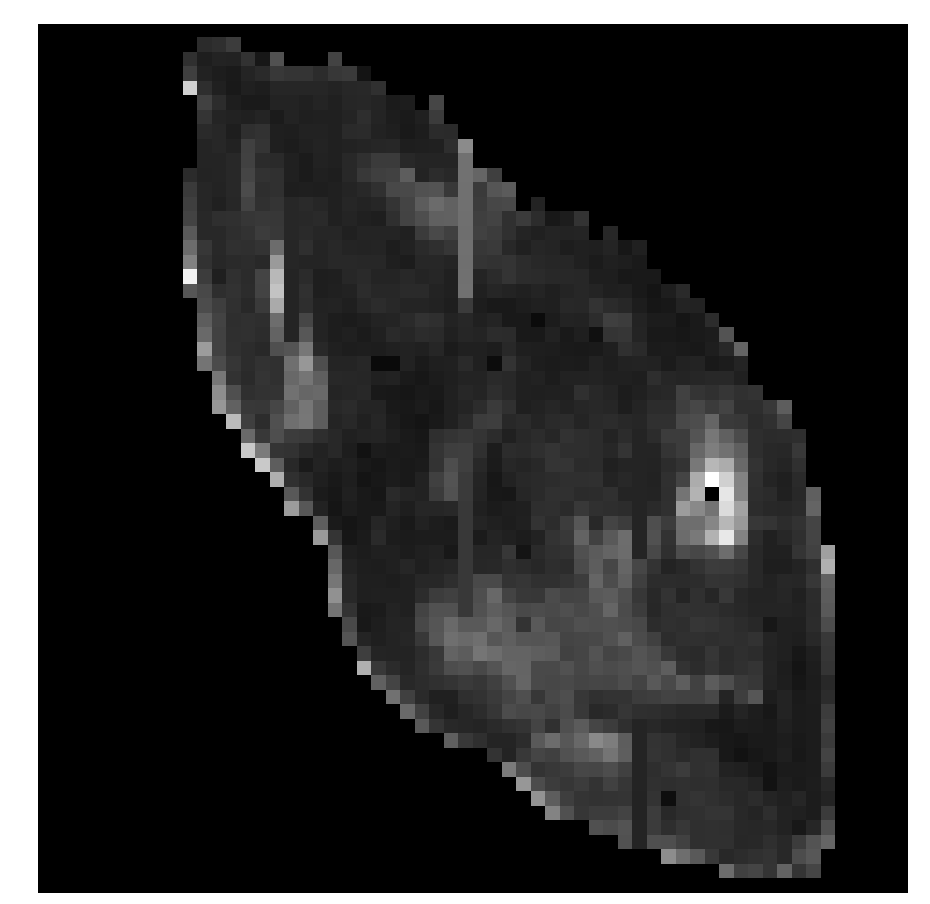

In [383]:
# Make a mask from the virtual dark-field image

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/DF_image.pdf"

fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.matshow(DF_image.data2D)
ax.axis('equal')
ax.axis('off')
plt.savefig(savepath)
plt.show()